In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import glob
import os
import fnmatch
from scipy import stats
import math

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
# regional domain
ldom = np.array([[46.5,47.5],[-125.1,-124]])
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

In [19]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
# order by bottom temp
fishdt = fishdt.sort_values('Tm', ignore_index=True)
# drop albacore for now, to do only present fisheries
fishdt = fishdt.drop([len(fishdt)-1])
# drop black fish for now
fishdt = fishdt.drop([len(fishdt)-2])
fishdt = fishdt.reset_index(drop=True)
fishes=fishdt['Species']
fishdt

,Species,Dx,Dm,Tx,Tm,Om
0,P. Halibut,515,155,9.28,2.92,1.246501
1,Chinook,172,43,11.65,3.49,1.218513
2,Coho,118,28,12.35,4.43,1.319720
3,Sablefish,1450,175,12.85,4.72,0.786592
4,Dungeness Crab,90,41,11.72,5.36,2.416202
5,Razor Clams,28,5,12.73,5.99,2.472851


In [20]:
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245','ssp585']

In [21]:
def T_weighted_suitable_habitat(fishnum):
    import math
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    nyw = (yw-ymin)/ymax
    #plt.plot(xw, nyw)
    #plt.show()
    
    return xw, nyw
    

In [22]:
pdf_fdir = '../data/Downscaleddata/pdfs/'
pdf_surf = pd.read_excel(pdf_fdir+'surface thetao_pdf.xlsx', index_col=0)
print(list(pdf_surf))
pdf_sthr = pd.read_excel(pdf_fdir+'surface thetao_thresholds.xlsx', index_col=0)
pdf_bott = pd.read_excel(pdf_fdir+'bottom thetao_pdf.xlsx', index_col=0)
pdf_bthr = pd.read_excel(pdf_fdir+'bottom thetao_thresholds.xlsx', index_col=0)
pdf_bthr

['obs_x', 'obs_y', 'p1_x_245', 'p1_y_245', 'p2_x_245', 'p2_y_245', 'p1_x_585', 'p1_y_585', 'p2_x_585', 'p2_y_585']


,obs_90,obs_10,p1_90_245,p1_10_245,p2_90_245,p2_10_245,p1_90_585,p1_10_585,p2_90_585,p2_10_585
0,9.249492,7.249047,9.490613,6.940963,10.78534,7.983047,9.567286,7.110559,11.277947,8.137051


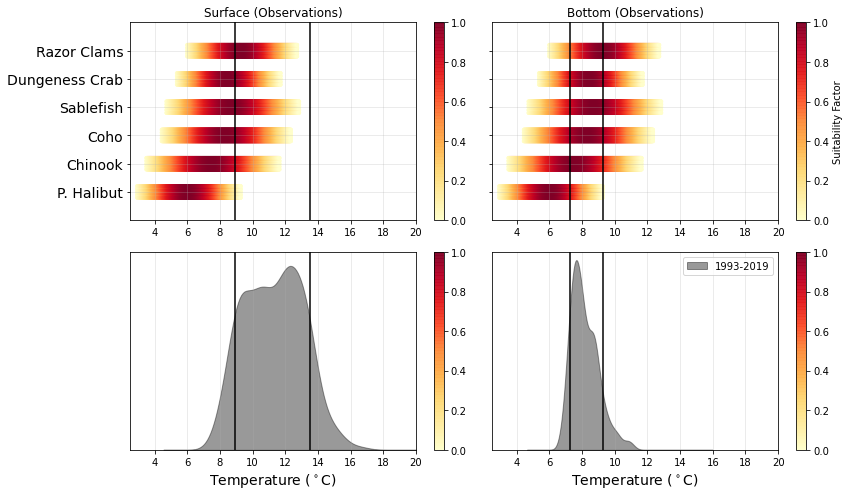

In [23]:
# observations
fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (Observations)')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['obs_x'],pdf_surf['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(pdf_sthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.grid(True,alpha=0.3, zorder=0)

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)

plt.axvline(pdf_bthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (Observations)')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['obs_x'],pdf_bott['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(pdf_bthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0)
plt.grid(True,alpha=0.3, zorder=0)

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/T_obs_current.png')
plt.show()

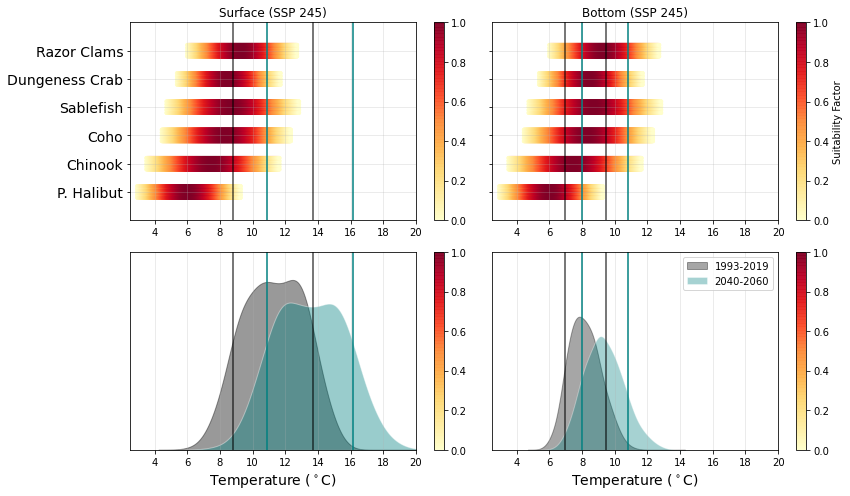

In [24]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
ssp='245'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['p1_x_'+ssp],pdf_surf['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf['p2_x_'+ssp],pdf_surf['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.grid(True,alpha=0.3, zorder=0)

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['p1_x_'+ssp],pdf_bott['p1_y_'+ssp],fc=c1, ec='k',alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott['p2_x_'+ssp],pdf_bott['p2_y_'+ssp],fc=c2, ec='w',alpha=0.35, label='2040-2060')
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0)
plt.grid(True,alpha=0.3, zorder=0)

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/T_ssp245_current.png')

plt.show()

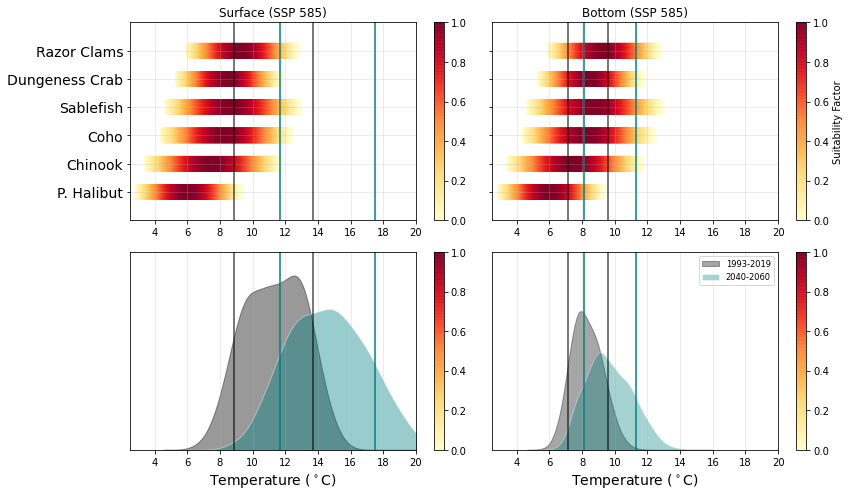

In [25]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
ssp='585'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['p1_x_'+ssp],pdf_surf['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf['p2_x_'+ssp],pdf_surf['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.grid(True,alpha=0.3 , zorder=0)

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.grid(True,alpha=0.3, zorder=0)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['p1_x_'+ssp],pdf_bott['p1_y_'+ssp],color=c1, alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott['p2_x_'+ssp],pdf_bott['p2_y_'+ssp],fc=c2, ec='w', alpha=0.35, label='2040-2060')
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws, alpha=0.7)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0, fontsize='small')
plt.grid(True,alpha=0.3, zorder=0)

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/T_ssp585_current.png')

plt.show()

In [26]:
pdf_surf_o2 = pd.read_excel(pdf_fdir+'surface o2_pdf.xlsx', index_col=0)
print(list(pdf_surf_o2))
pdf_bott_o2 = pd.read_excel(pdf_fdir+'bottom o2_pdf.xlsx', index_col=0)

['obs_x', 'obs_y', 'p1_x_245', 'p1_y_245', 'p2_x_245', 'p2_y_245', 'p1_x_585', 'p1_y_585', 'p2_x_585', 'p2_y_585']


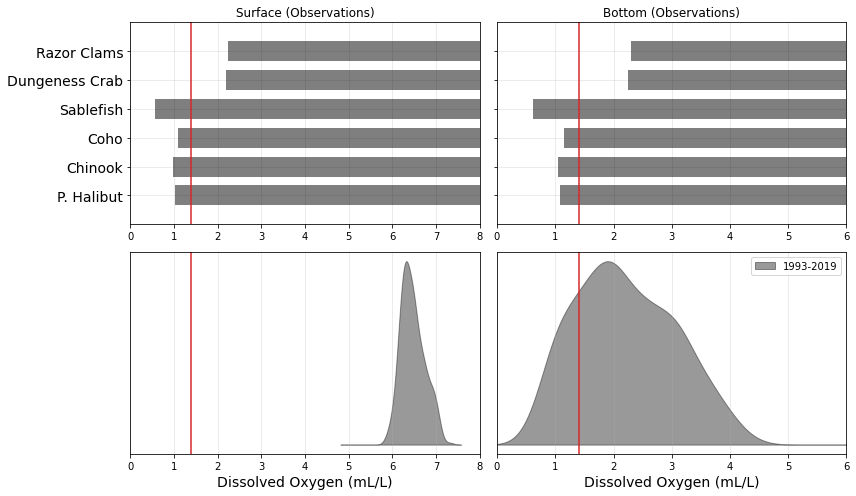

In [27]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
c3='tab:red'
ssp='obs'
hyp = 1.4

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishdt)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 8])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Surface (Observations)')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf_o2['obs_x'],pdf_surf_o2['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,8])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (mL/L)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
#plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 6])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Bottom (Observations)')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott_o2['obs_x'],pdf_bott_o2['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,6])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (mL/L)', fontsize=14)
plt.legend(loc=0)

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/O_obs_current.png')

plt.show()

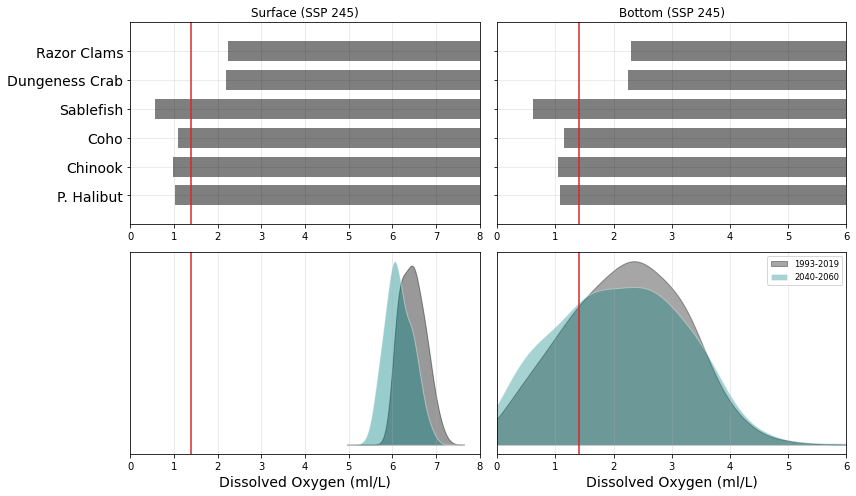

In [28]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
c3='tab:red'
ssp='245'
hyp=1.4

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishdt)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 8])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf_o2['p1_x_'+ssp],pdf_surf_o2['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf_o2['p2_x_'+ssp],pdf_surf_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,8])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 6])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott_o2['p1_x_'+ssp],pdf_bott_o2['p1_y_'+ssp],fc=c1, ec='k',alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott_o2['p2_x_'+ssp],pdf_bott_o2['p2_y_'+ssp],fc=c2, ec='w',alpha=0.35, label='2040-2060')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,6])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/O_ssp245_current.png')

plt.show()

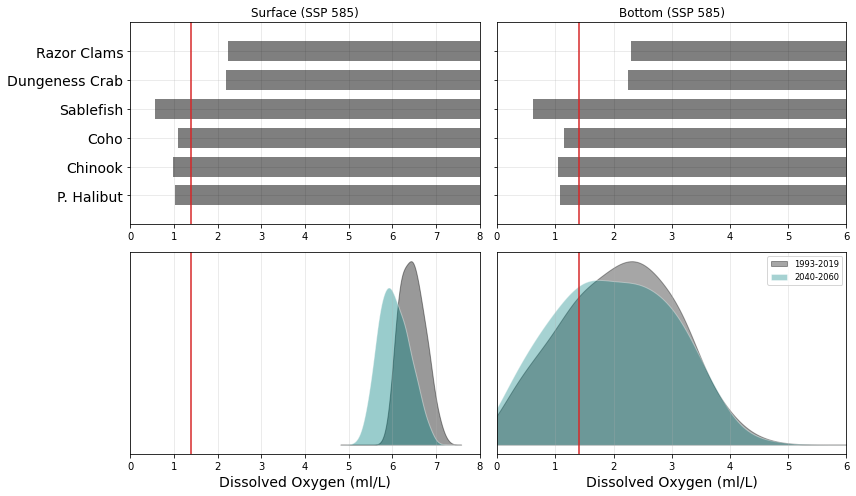

In [29]:
fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
ssp='585'
hyp=1.4

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishdt)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 8])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf_o2['p1_x_'+ssp],pdf_surf_o2['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf_o2['p2_x_'+ssp],pdf_surf_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,8])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    plt.plot([fishdt['Om'][fishn],15],[fishn, fishn],'-', lw=20, c='k',alpha=0.5)
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks(range(len(fishdt)),fishdt['Species'], fontsize=14)
plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishdt)])
plt.xlim([0, 6])
plt.grid(True,alpha=0.3, zorder=0)
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott_o2['p1_x_'+ssp],pdf_bott_o2['p1_y_'+ssp],fc=c1, ec='k',alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott_o2['p2_x_'+ssp],pdf_bott_o2['p2_y_'+ssp],fc=c2, ec='w',alpha=0.35, label='2040-2060')
plt.axvline(hyp,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([0,6])
plt.grid(True,alpha=0.3, zorder=0)
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.savefig('../figures/fish_ocean_ranges/O_ssp585_current.png')
plt.show()

In [30]:
pdf_bott_o2

,obs_x,obs_y,p1_x_245,p1_y_245,p2_x_245,p2_y_245,p1_x_585,p1_y_585,p2_x_585,p2_y_585
0,-1.006892,0.000146,-1.122610,0.000220,-1.122610,0.000306,-1.006892,0.000236,-1.006892,0.000270
1,-0.970271,0.000146,-1.080835,0.000249,-1.080835,0.000313,-0.970271,0.000269,-0.970271,0.000292
2,-0.933651,0.000146,-1.039059,0.000288,-1.039059,0.000355,-0.933651,0.000317,-0.933651,0.000346
3,-0.897030,0.000146,-0.997283,0.000340,-0.997283,0.000450,-0.897030,0.000404,-0.897030,0.000442
4,-0.860409,0.000146,-0.955508,0.000408,-0.955508,0.000587,-0.860409,0.000520,-0.860409,0.000601
...,...,...,...,...,...,...,...,...,...,...
195,6.134143,0.000056,7.023653,0.000129,7.023653,0.000116,6.134143,0.000110,6.134143,0.000099
196,6.170764,0.000056,7.065429,0.000129,7.065429,0.000107,6.170764,0.000110,6.170764,0.000099
197,6.207385,0.000056,7.107205,0.000129,7.107205,0.000099,6.207385,0.000110,6.207385,0.000099
198,6.244005,0.000056,7.148981,0.000129,7.148981,0.000093,6.244005,0.000110,6.244005,0.000099
